In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader,Dataset

import torch.optim as optim

import matplotlib.pyplot as plt

![](./images/architecture.jpg)
Define the distribution of the mnist dataset, **p(x)** , as a infinite mixture of vectors of bernoulli distributions conditioned on the latent variable t. Where, the bernoulli states that a pixel is black with probability *p* or white with probability *1-p*

The introduction of the latent variable allows an EM approach to be applied, where a variational lower bound is defined based on **log p(x)**

![](./equations/px_lowerbound.jpg)

In [2]:
n_epochs = 10
batch_size_train = 64
learning_rate = 0.001
latent_dim = 2

In [3]:
train_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
                            
                                           
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)

The encoder may be seen as a variational approximation fixed as a gaussian with diagonal covariance matrix of the posterior distribution **p(t|x)**, 
![](./equations/e_step.jpg)

A reparametarization trick is introduced to create a continous gradient flow of the variational autoencoder, as well as lower the variance of the gradient of the lower bound with respect to the decoders weights.
![](./equations/reparametarization.jpg)

In [4]:
class encoder(nn.Module):
    def __init__(self,latent_dim):
        super(encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, latent_dim*2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The decoder may be seen as the vectors of bernoulli, **p(x|t,w)**
![](./equations/px_distribution.jpg)

In [5]:
class decoder(nn.Module):
    def __init__(self,latent_dim):
        super(decoder,self).__init__()
        self.fc1 = nn.Linear(latent_dim,64)
        self.fc2 = nn.Linear(64,256)
        self.fc3 = nn.Linear(256,784)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x.view(-1,28*28)
        

In [6]:
class sampler(nn.Module):
    def __init__(self,latent_dim):
        super(sampler,self).__init__()
        self.size = latent_dim
    def forward(self,mu,var):
        batch_size = mu.shape[0]
        z = torch.randn((batch_size,latent_dim)) * .5 * torch.exp(var) + mu
        return z

In [7]:
get_t_mean = lambda h: h[:, :latent_dim]
get_t_log_var = lambda h: h[:, latent_dim:]

In [8]:
class VAE(nn.Module):
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.VAE_encoder = encoder(latent_dim)
        self.VAE_decoder = decoder(latent_dim)
        self.reparam = sampler(latent_dim)

    def encode(self,x):
        return self.VAE_encoder(x)
    
    def decode(self,x):
        return self.VAE_decoder(x)
    
    def sample(self,mu,var):
        return self.reparam(mu,var)

The variational lower bound may be rewritten (and approximated with MC methods)
![](./equations/lower_bound_objective.jpg)


In [9]:
class VLB_loss(nn.Module):
    def __init__(self):
        super(VLB_loss,self).__init__()
        self.bce = nn.BCELoss(reduction='none')
    
    def forward(self,x,x_decoded_mean,t_mean,t_log_var):
        klterm = 0.5*torch.sum(-1-t_log_var + t_mean**2 + torch.exp(t_log_var),1)
        reconst = torch.sum(self.bce(x_decoded_mean,x),1)
        return torch.mean(klterm+reconst)

In [10]:
VAE_net = VAE(latent_dim)

In [11]:
optimizer = optim.Adam(VAE_net.parameters(),lr=learning_rate)

In [12]:
criterion = VLB_loss()

In [13]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize    
        encoded_x = VAE_net.encode(inputs)

        t_mean = get_t_mean(encoded_x)
        t_log_var = get_t_log_var(encoded_x)
        t = VAE_net.sample(t_mean,t_log_var)

        decoded_x = VAE_net.decode(t)

        loss = criterion(torch.round(labels.view(-1,28*28)),decoded_x,t_mean,t_log_var)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    print('Finished Training')

[1,   100] loss: 12.414
[1,   200] loss: 10.223
[1,   300] loss: 9.555
[1,   400] loss: 9.302
[1,   500] loss: 8.926
[1,   600] loss: 8.662
[1,   700] loss: 8.485
[1,   800] loss: 8.395
[1,   900] loss: 8.266
Finished Training
[2,   100] loss: 8.167
[2,   200] loss: 8.114
[2,   300] loss: 8.020
[2,   400] loss: 7.971
[2,   500] loss: 7.898
[2,   600] loss: 7.884
[2,   700] loss: 7.877
[2,   800] loss: 7.851
[2,   900] loss: 7.809
Finished Training
[3,   100] loss: 7.709
[3,   200] loss: 7.702
[3,   300] loss: 7.713
[3,   400] loss: 7.688
[3,   500] loss: 7.572
[3,   600] loss: 7.624
[3,   700] loss: 7.627
[3,   800] loss: 7.535
[3,   900] loss: 7.572
Finished Training
[4,   100] loss: 7.476
[4,   200] loss: 7.468
[4,   300] loss: 7.487
[4,   400] loss: 7.410
[4,   500] loss: 7.414
[4,   600] loss: 7.367
[4,   700] loss: 7.393
[4,   800] loss: 7.410
[4,   900] loss: 7.321
Finished Training
[5,   100] loss: 7.338
[5,   200] loss: 7.276
[5,   300] loss: 7.242
[5,   400] loss: 7.299
[5,   

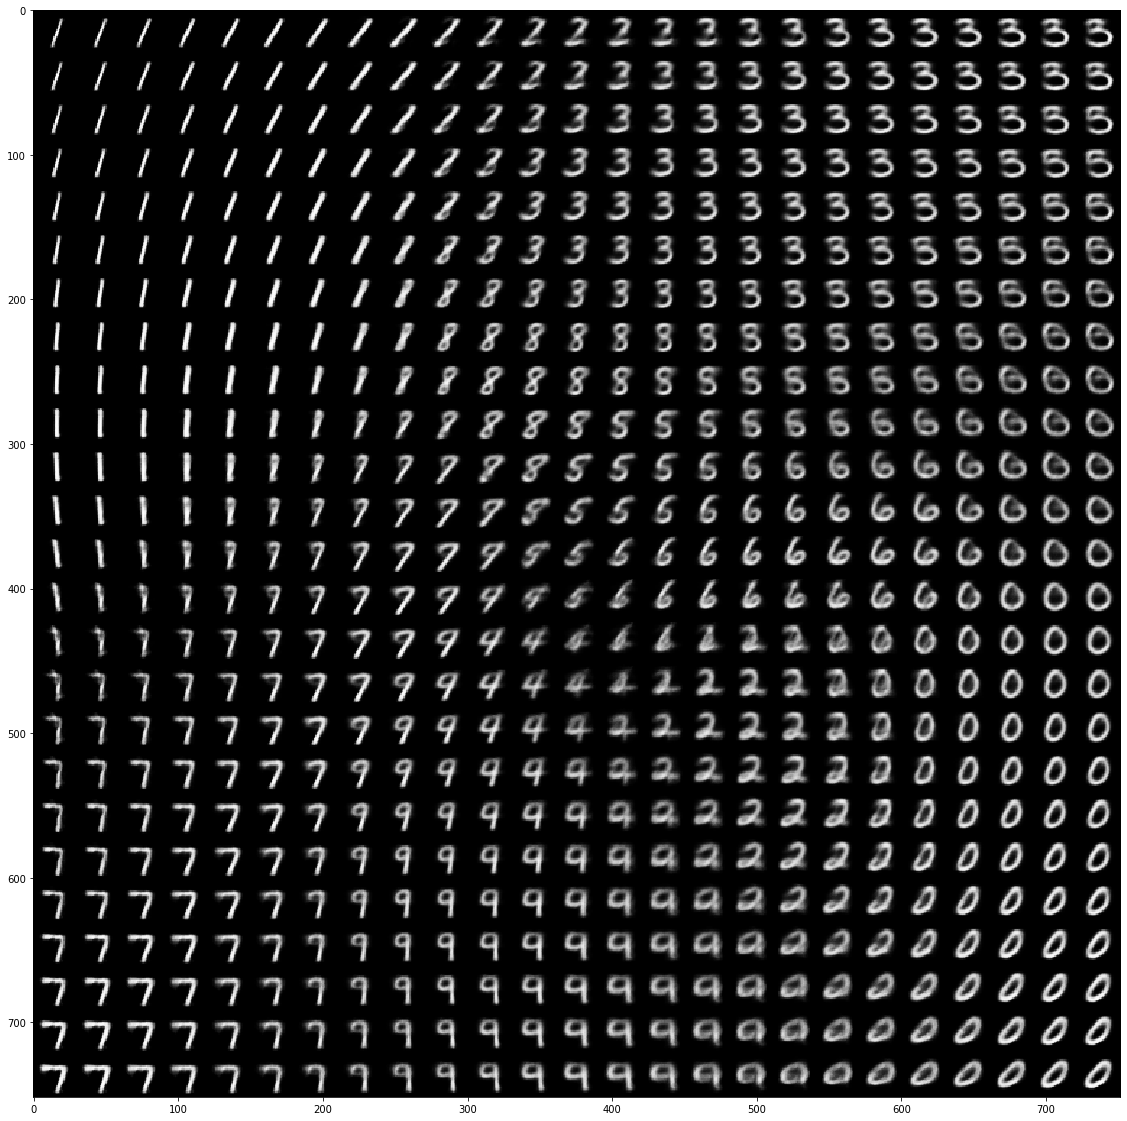

In [41]:
with torch.no_grad():
    n_points = 25
    x = torch.linspace(-1.75,1.75,n_points)
    y = torch.linspace(-1.75,1.75,n_points)
    grid_x, grid_y = torch.meshgrid(x, y)
    t = torch.cat((grid_x.flatten().unsqueeze(1),grid_y.flatten().unsqueeze(1)),1)
    decoded_x = VAE_net.decode(t)
    in_grid = torchvision.utils.make_grid(decoded_x.view(n_points**2,1,28,28),nrow=n_points)[0]
    plt.figure(figsize=(20,20))
    plt.imshow(in_grid,cmap='gray')